In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.plot_keypoints import show_keypoints
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans

In [2]:
angle_fb_data = pd.read_csv("data/angle_full_body.csv")
fb_data = pd.read_csv("data/no_dup_full_body.csv")

In [3]:
angle_fb_data.shape, fb_data.shape

((23171, 6), (23171, 34))

In [4]:
n_clusters = 4

# KMEANS

In [5]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(angle_fb_data)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

/home/webis/miniconda3/envs/pifpaf/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [6]:
cluster_counts = np.bincount(labels, minlength=n_clusters)

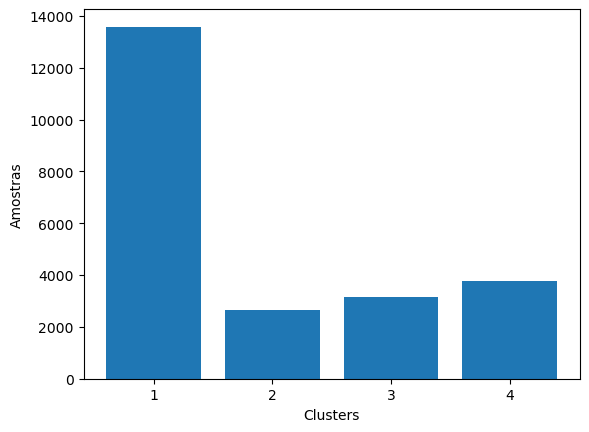

In [9]:
# Plot the cluster frequency
plt.bar(range(1,n_clusters+1), cluster_counts)
plt.xlabel('Clusters')
plt.ylabel('Amostras')
#plt.title('Cluster Frequency Distribution')
plt.xticks(range(1,n_clusters+1))
plt.savefig("Results/samples_distribution.png")
plt.show()

In [8]:
closest_points_df = pd.DataFrame(columns=angle_fb_data.columns)

In [9]:
for center in centers:
    distances = angle_fb_data.apply(lambda row: euclidean(row, center), axis=1)
    closest_point_idx = distances.idxmin()
    closest_points_df = closest_points_df.append(angle_fb_data.loc[closest_point_idx])

/tmp/ipykernel_16721/3033368338.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  closest_points_df = closest_points_df.append(angle_fb_data.loc[closest_point_idx])
/tmp/ipykernel_16721/3033368338.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  closest_points_df = closest_points_df.append(angle_fb_data.loc[closest_point_idx])
/tmp/ipykernel_16721/3033368338.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  closest_points_df = closest_points_df.append(angle_fb_data.loc[closest_point_idx])
/tmp/ipykernel_16721/3033368338.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  closest_points_df = closest_points_df.append(angle_fb_data.

In [10]:
closest_points_df

,left_elbow,right_elbow,left_shoulder,right_shoulder,left_knee,right_knee
7749,96.972791,-91.972483,23.424999,-25.549950,0.003386,0.536716
19999,-102.836837,94.513941,56.193534,-41.794540,-0.489885,5.152275
8292,90.354448,103.469651,30.363661,-23.268170,0.818170,-0.457613
5202,-75.591408,-81.164211,21.624794,-21.252679,0.824659,1.099485


In [11]:
fb_data.loc[closest_points_df.index]

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
7749,424.15,213.03,426.43,210.85,422.13,211.07,431.13,212.73,419.76,213.23,...,418.47,261.34,434.28,289.66,415.22,289.78,435.88,318.10,412.54,317.85
19999,460.51,106.34,465.14,101.19,455.58,102.25,475.24,102.98,450.91,105.91,...,455.75,205.54,485.11,271.74,454.70,272.33,482.58,334.28,463.53,329.80
8292,430.22,154.59,432.05,152.91,428.61,152.97,434.91,154.89,426.71,155.00,...,427.80,189.39,436.35,211.17,428.51,210.95,437.95,230.44,428.84,229.05
5202,371.44,219.21,373.28,217.40,369.30,217.30,375.19,218.35,364.92,218.14,...,362.11,260.64,378.26,284.74,362.31,284.89,380.27,304.80,363.23,305.79


In [12]:
closest_points_df = fb_data.loc[closest_points_df.index]

In [13]:
for i in range(len(closest_points_df.values)):
    show_keypoints(closest_points_df.values[i].reshape(17,2), save_path=f'Results/KNNClusters/Cluster-{i}.jpg', show=False)

In [14]:
def read_json_files(folder_path):
    json_data = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            json_data[filename] = []
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r") as file:
                for line in file:
                    try:
                        line_data = json.loads(line)
                        json_data[filename].append(line_data)
                    except json.JSONDecodeError:
                        print(f"Error parsing JSON line: {line}")
    
    return json_data


In [15]:
file_path = "Videos"
json_data = read_json_files(file_path)

In [16]:
centers_frames = []

In [17]:
for cp in closest_points_df.values: 
    found_condition = False
    for key in json_data:
        for item in json_data[key]:
            frame_index = item["frame"]
            predictions = item["predictions"]
            for prediction in predictions:
                keypoints = prediction["keypoints"]
                bbox = prediction["bbox"]
                score = prediction["score"]
                category_id = prediction["category_id"]

                keypoints_arr = np.array(keypoints).reshape(-1, 3)  # Reshape keypoints as (n, 3) array
                c_values = keypoints_arr[:, 2]  # Extract all c values
                keypoints_without_c = keypoints_arr[:, :2].reshape(-1,34)
                
                if np.allclose(keypoints_without_c, cp):
                    print(key, frame_index)
                    #print(keypoints_without_c)
                    centers_frames.append([key, frame_index, keypoints_without_c])
                    found_condition = True
                    break
            if found_condition:
                break
        if found_condition:
            break

How to spot a liar Pamela Meyer.mp4.openpifpaf.json 9116
Tim Urban Inside the mind of a master procrastinator TED.mp4.openpifpaf.json 10463
How to stop screwing yourself over  Mel Robbins  TEDxSF.mp4.openpifpaf.json 16724
How to speak so that people want to listen Julian Treasure.mp4.openpifpaf.json 3750


In [18]:
import cv2

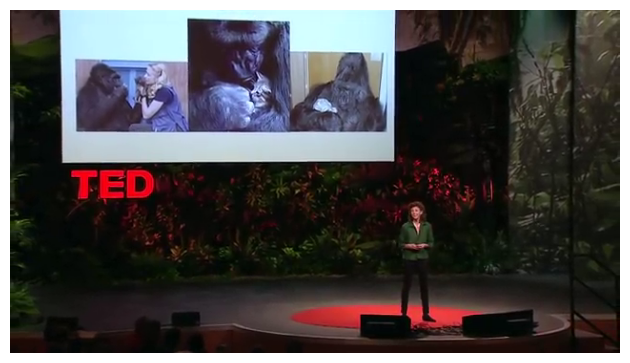

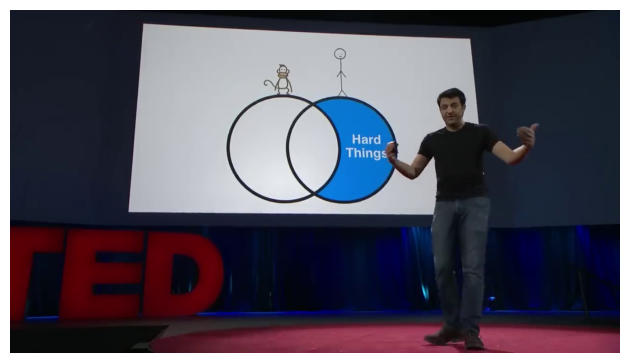

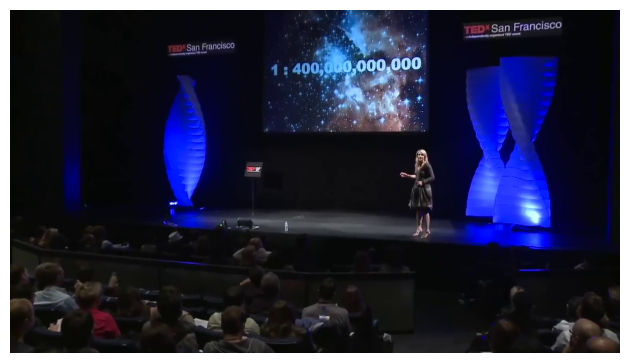

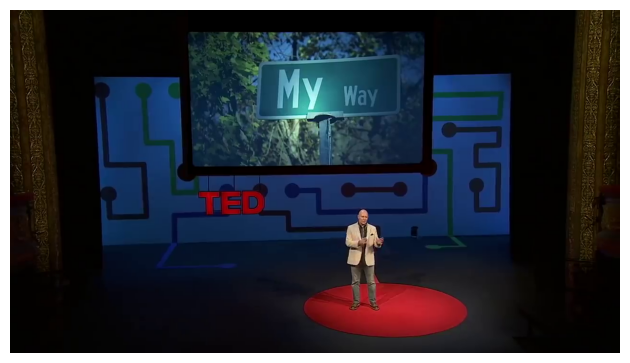

In [19]:
for i in range(len(centers_frames)):
    video_name = centers_frames[i][0].rsplit('.', 2)[0]
    video_path = f'Videos/{video_name}'

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        exit()

    target_frame_number = centers_frames[i][1]-1

    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_number)
    ret, frame = cap.read()

    if not ret:
        print("Error reading frame")
        exit()

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')  # Turn off axis labels and ticks
    #cv2.imwrite(f"Results/NearCenter/Cluster-{centers_frames[i]}.jpg", frame)
    plt.savefig(f"Results/NearCenter/Cluster-{i}.jpg", bbox_inches='tight', pad_inches=0)
    plt.tight_layout()
    #plt.show()
    cap.release()

    keypoints = centers_frames[i][2].reshape(17,2)
    show_keypoints(keypoints, save_path=f"Results/NearCenter/Cluster-{i}-Keypoints.jpg", show=False)